In [1]:
import abc
import logging
import os
import re
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
from kerosene.utils.files import extract_file_paths
from samitorch.inputs.transformers import ToNumpyArray
from torchvision.transforms import transforms

/home/pierre-luc-delisle/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
class AbstractPreProcessingPipeline(metaclass=abc.ABCMeta):
    """
    Define a preprocessing pipeline.
    """

    @staticmethod
    def _get_image_affine(file):
        return nib.load(file).affine

    @staticmethod
    def _get_image_header(file):
        return nib.load(file).header

    @abc.abstractmethod
    def run(self, **kwargs):
        """
        Run the preprocessing pipeline.
        Args:
            **kwargs: Optional keyword arguments.
        """
        raise NotImplementedError

In [3]:
class ABIDEImageExtraction(AbstractPreProcessingPipeline):
    LOGGER = logging.getLogger("PreProcessingPipeline")

    def __init__(self, source_dir: str):
        self._source_dir = source_dir
        self._transforms = transforms.Compose([ToNumpyArray()])

    def run(self, sites = None):
        source_paths = list()
        target_paths = list()
        images = list()
        labels = list()
        
        if sites is not None:
            dirs = [dir for dir in sorted(os.listdir(self._source_dir)) if any(substring in dir for substring in sites)]
        else:
            dirs = [dir for dir in sorted(os.listdir(self._source_dir))]
        
        for dir in sorted(dirs):
            image_path = os.path.join(self._source_dir, dir, "mri", "real_brainmask.nii.gz")
            label_path = os.path.join(self._source_dir, dir, "mri", "aligned_labels.nii.gz")
            if os.path.exists(image_path):
                source_paths.append(image_path)
            if os.path.exists(label_path):
                target_paths.append(label_path)
        
        for source_path, target_path in zip(source_paths, target_paths):
            images.append(self._transforms(source_path))
            labels.append(self._transforms(target_path))
            
        return np.array(images), np.array(labels)

In [4]:
ABIDE_path = "/home/pierre-luc-delisle/ABIDE/5.1"

MemoryError: Unable to allocate array with shape (184, 1, 211, 212, 189) and data type float64

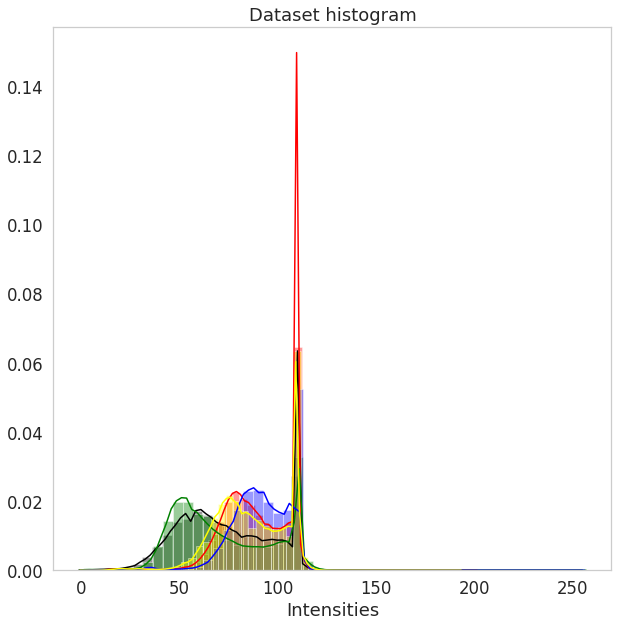

In [5]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
plt.subplots(figsize=(10,10))
ABIDE_images_stanford, ABIDE_seg_stanford = ABIDEImageExtraction(ABIDE_path).run(sites=["Stanford"])
sns.distplot(ABIDE_images_stanford.flatten()[np.nonzero(ABIDE_images_stanford.flatten())], hist=True, norm_hist=True, kde=True, color="black", label="Stanford", axlabel="Intensities").set_title("Dataset histogram")
del ABIDE_images_stanford
del ABIDE_seg_stanford

ABIDE_images_cmu, ABIDE_seg_cmu = ABIDEImageExtraction(ABIDE_path).run(sites=["CMU"])
ax = sns.distplot(ABIDE_images_cmu.flatten()[np.nonzero(ABIDE_images_cmu.flatten())], hist=True, norm_hist=True, kde=True, color="red", label="CMU")
del ABIDE_images_cmu
del ABIDE_seg_cmu

ABIDE_images_kki, ABIDE_seg_kki = ABIDEImageExtraction(ABIDE_path).run(sites=["KKI"])
ax = sns.distplot(ABIDE_images_kki.flatten()[np.nonzero(ABIDE_images_kki.flatten())], hist=True, norm_hist=True, kde=True, color="green", label="KKI")
del ABIDE_images_kki
del ABIDE_seg_kki

ABIDE_images_caltech, ABIDE_seg_caltech = ABIDEImageExtraction(ABIDE_path).run(sites=["Caltech"])
ax = sns.distplot(ABIDE_images_caltech.flatten()[np.nonzero(ABIDE_images_caltech.flatten())], hist=True, norm_hist=True, kde=True, color="blue", label="Caltech")
del ABIDE_images_caltech
del ABIDE_seg_caltech

ABIDE_images_maxmun, ABIDE_seg_maxmun = ABIDEImageExtraction(ABIDE_path).run(sites=["MaxMun"])
ax = sns.distplot(ABIDE_images_maxmun.flatten()[np.nonzero(ABIDE_images_maxmun.flatten())], hist=True, norm_hist=True, kde=True, color="yellow", label="MaxMun")
del ABIDE_images_maxmun
del ABIDE_seg_maxmun

ABIDE_images_nyu, ABIDE_seg_nyu = ABIDEImageExtraction(ABIDE_path).run(sites=["NYU"])
ax = sns.distplot(ABIDE_images_nyu.flatten()[np.nonzero(ABIDE_images_nyu.flatten())], hist=True, norm_hist=True, kde=True, color="cyan", label="NYU")
del ABIDE_images_nyu
del ABIDE_seg_nyu

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Intensities_ABIDE_10x10.png")

In [ ]:
plt.subplots(figsize=(10,10))
sns.distplot(ABIDE_images_stanford[np.where(ABIDE_seg_stanford==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF",  axlabel="Intensities").set_title("Class overlap in iSEG")
sns.distplot(ABIDE_images_stanford[np.where(ABIDE_seg_stanford==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter")
ax = sns.distplot(ABIDE_images_stanford[np.where(ABIDE_seg_stanford==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter")
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap iSEG_10x10.png")

In [ ]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter")
ax = sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter")
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap MRBrainS_10x10.png")

In [ ]:
width = 0.35  # the width of the bars
labels = ["CSF", "Gray Matter", "White Matter"]
x = np.arange(len(labels))  # the label locations
fig, ax = plt.subplots()

total_mrbrains = np.unique(mrbrains_seg, return_counts=True)[1][1:4].sum()
total_iseg = np.unique(iseg_seg, return_counts=True)[1][1:4].sum()
rects1 = ax.bar(x-width/2, np.unique(mrbrains_seg, return_counts=True)[1][1:4]/total_mrbrains, width, label="MRBrainS", color='b')
rects2 = ax.bar(x+width/2, np.unique(iseg_seg, return_counts=True)[1][1:4]/total_iseg, width, label="iSEG", color='r')
ax.set_ylabel('Voxel count (%)')
ax.set_title('Voxel count per class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()
fig.savefig("Voxel count.png")

In [ ]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color="r", label="CSF iSEG")

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap class1_10x10.png")

In [ ]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, kde=True, color="b", label="GM MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True, color="r", label="GM iSEG")

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap class2_10x10.png")

In [ ]:
plt.subplots(figsize=(10,10))
sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color="b", label="WM MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="WM iSEG")
plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap class3_10x10.png")

In [ ]:
red_1 = sns.color_palette("RdBu", n_colors=8)[0]
red_2 = sns.color_palette("RdBu", n_colors=8)[2]
blue_1 = sns.color_palette("RdBu", n_colors=8)[7]
blue_2 = sns.color_palette("RdBu", n_colors=8)[5]
green_1 = sns.color_palette("Greens_r", n_colors=8)[0]
green_2 = sns.color_palette("Greens_r", n_colors=8)[4]

In [ ]:
plt.subplots(figsize=(10,10))
sns.color_palette("muted")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color=blue_1, label="CSF MRBrainS")
sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color=blue_2, label="CSF iSEG")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, color=red_1, kde=True, label="GM MRBrainS")
sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True,  color=red_2, label="GM iSEG")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color=green_1, label="WM MRBrainS")
ax = sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color=green_2, label="WM iSEG")

plt.legend()
plt.show()
fig = ax.get_figure()
fig.savefig("Overlap all_10x10.png")

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True)

sns.distplot(mrbrains_images.flatten()[np.nonzero(mrbrains_images.flatten())], hist=True, norm_hist=True, kde=True, color="b", label="MRBrainS", axlabel="Intensities", ax=axes[0]).set_title("Dataset histogram")
sns.distplot(iseg_images.flatten()[np.nonzero(iseg_images.flatten())], hist=True, norm_hist=True, kde=True, color="r", label="iSEG", ax=axes[0])

sns.distplot(iseg_images[np.where(iseg_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF",  axlabel="Intensities", ax=axes[1]).set_title("Class overlap in iSEG")
sns.distplot(iseg_images[np.where(iseg_seg==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter", ax=axes[1])
sns.distplot(iseg_images[np.where(iseg_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter", ax=axes[1])

sns.distplot(mrbrains_images[np.where(mrbrains_seg==1)], hist=True, norm_hist=True, kde=True, color="b", label="CSF", axlabel="Intensities", ax=axes[2]).set_title("Class overlap in MRBrainS")
sns.distplot(mrbrains_images[np.where(mrbrains_seg==2)], hist=True, norm_hist=True, kde=True, color="g", label="Gray Matter", ax=axes[2])
sns.distplot(mrbrains_images[np.where(mrbrains_seg==3)], hist=True, norm_hist=True, kde=True, color="r", label="White Matter", ax=axes[2])

plt.legend()

plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

In [ ]:
nb_voxels_class_0 = np.count_nonzero(iseg_images[np.where(iseg_seg==0)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==0)])
nb_voxels_class_1 = np.count_nonzero(iseg_images[np.where(iseg_seg==1)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==1)])
nb_voxels_class_2 = np.count_nonzero(iseg_images[np.where(iseg_seg==2)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==2)])
nb_voxels_class_3 = np.count_nonzero(iseg_images[np.where(iseg_seg==3)]) + np.count_nonzero(mrbrains_images[np.where(mrbrains_seg==3)])

print(nb_voxels_class_1)
total = nb_voxels_class_0 + nb_voxels_class_1 + nb_voxels_class_2 + nb_voxels_class_3

weights = [nb_voxels_class_0/total, nb_voxels_class_1 / total, nb_voxels_class_2 / total, nb_voxels_class_3 / total]
print(weights)
print(weights[0] + weights[1] + weights[2])
total = nb_voxels_class_1 + nb_voxels_class_2 + nb_voxels_class_3
weights = [nb_voxels_class_1 / total, nb_voxels_class_2 / total, nb_voxels_class_3 / total]
print(weights)